In [1]:
import hppfcl as fcl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pinocchio as pin
import seaborn as sns

from common.panda_loader import load_panda
from common.load_pickle import load_pickle
%run common/plot_defaults.py

/tmp/ipykernel_243619/2906802026.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
b = load_pickle()

/home/kwojciecho/Documents/post-treatment-panda-torque-mpc/pickle


In [3]:
rmodel, cmodel = load_panda()

def compute_end_effector_position(q):
    # Creates data models
    rdata = rmodel.createData()
    cdata = cmodel.createData()

    # Updating the models
    pin.framesForwardKinematics(rmodel, rdata, q)
    pin.updateGeometryPlacements(rmodel, rdata, cmodel, cdata, q)

    return rdata.oMf[rmodel.getFrameId("panda2_hand")].translation

def get_end_pose(df_curr):
    q_arr = df_curr[4]["joint_state.position"]
    pose_array = np.zeros((q_arr.shape[0], 3))
    for i in range(pose_array.shape[0]):
        pose_array[i] = compute_end_effector_position(
            np.array(eval(q_arr[i]))
        )
    return pose_array

In [4]:
pose_df = pd.DataFrame(columns=["Time", "x", "y", "z", "case"])
df_curr_pose_collision = b["2024-02-13-19-59-20.pkl"]

data_frames = (
    (df_curr_pose_collision, "Obstacle avoiding trajectory", 0.0),
)

for df_pose, case, offset in data_frames:
    case_pose_df = pd.DataFrame(columns=["Time", "x", "y", "z", "case"])

    pose_array = get_end_pose(df_pose)
    case_pose_df["Time"] = df_pose[4]["Time"] - df_pose[4]["Time"][0] - offset
    case_pose_df["x"] = pose_array[:, 0]
    case_pose_df["y"] = pose_array[:, 1]
    case_pose_df["z"] = pose_array[:, 2] - 0.825
    case_pose_df["case"] = case
    pose_df = pd.concat((pose_df, case_pose_df))

/tmp/ipykernel_243619/1934845690.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pose_df = pd.concat((pose_df, case_pose_df))


In [5]:
obstacle_df = b["2024-02-13-19-59-20.pkl"][2]

(-0.4136469716203269,
 0.4313452541121872,
 -0.38229842442489687,
 0.36213691950337185)

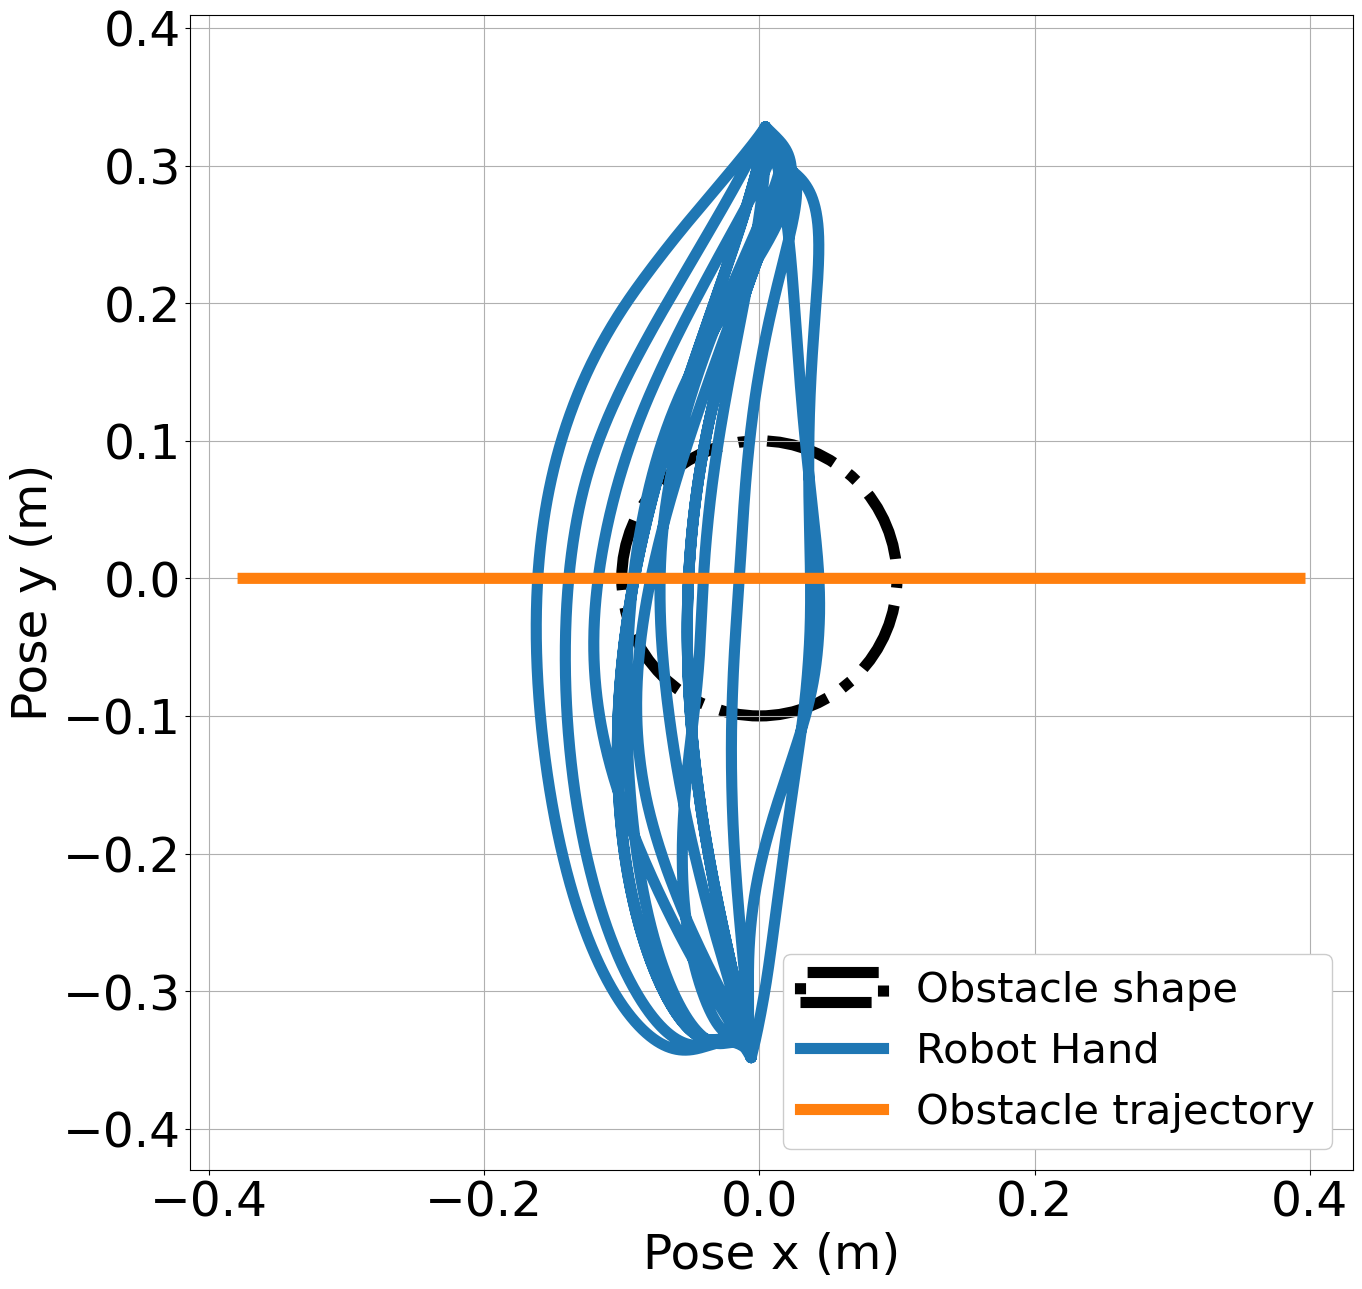

In [6]:
fig, axs = plt.subplots(figsize=(15, 15))

sns.set_palette("colorblind")

axs.add_patch(plt.Circle(
    (0.0, 0.0), 0.1, 
    color="#000000",
    linewidth=8.0,
    linestyle="-.",
    label="Obstacle shape",
    fill=False)
)

sns.lineplot(
    pose_df,
    x="x",
    y="y",
    label="Robot Hand",
    linewidth=8.0,
    sort=False
)

sns.lineplot(
    obstacle_df,
    x="pose.position.x",
    y=f"pose.position.y",
    label="Obstacle trajectory",
    linewidth=8.0
)


axs.set_xlabel("Pose x (m)")
axs.set_ylabel("Pose y (m)")
axs.axis('equal')

# plt.tight_layout()
# plt.savefig(
#     "end_effector_pose.svg",
#     format="svg",
#     pad_inches=1.5,
#     bbox_inches=Bbox([[0.5, 0], [26.5, 18]]),
# )

In [7]:
import plotly.express as px
df = px.data.iris()
fig = px.line_3d(pose_df, x='x', y='y', z='z')
fig.show()